In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Display 100 characters max within a cell
pd.set_option('max_colwidth',200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('text_emotion.csv')

## Data Understanding and Preprocessing

In [3]:
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


It looks like there are lots of different characters, creative spelling and punctuation, misspellings, slang, new words or URLs. This needs to be fixed

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
pd.DataFrame([df.sentiment.value_counts(), df.sentiment.value_counts(normalize=True)]).T

,sentiment,sentiment
neutral,8638.0,0.215950
worry,8459.0,0.211475
happiness,5209.0,0.130225
sadness,5165.0,0.129125
love,3842.0,0.096050
surprise,2187.0,0.054675
fun,1776.0,0.044400
relief,1526.0,0.038150
hate,1323.0,0.033075
empty,827.0,0.020675


There are no empty rows 

Lets see the group of sentiments on a graph

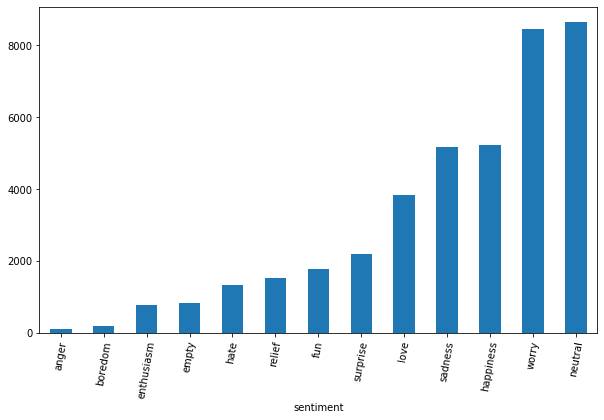

In [6]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [7]:
df.describe(include='object')

,sentiment,author,content
count,40000,40000,40000
unique,13,33871,39827
top,neutral,MissxMarisa,I just received a mothers day card from my lovely daughter wishing my a happy mothers day http://tr.im/kWK9
freq,8638,23,14


In [8]:
df.isnull().sum()

tweet_id     0
sentiment    0
author       0
content      0
dtype: int64

No missing values

In [9]:
df.content.duplicated().sum()

173

It looks like there are duplicated tweets (which could be retweets maybe) that needs to be taken into consideration

In [10]:
df.content.value_counts()[df.content.value_counts()>1]

I just received a mothers day card from my lovely daughter wishing my a happy mothers day  http://tr.im/kWK9    14
FREE UNLIMITED RINGTONES!!! - http://tinyurl.com/freeringring - USA ONLY - Awesome 4 iphone                     13
Happy Mother's Day!                                                                                             10
Happy Mothers Day                                                                                               10
happy mother's day                                                                                               8
                                                                                                                ..
Good Morning Everyone                                                                                            2
at home sick                                                                                                     2
@mcraddictal                                                                    

In [11]:
df[df.content=='happy mothers day']

,tweet_id,sentiment,author,content
29348,1751177832,love,jadeeisabel,happy mothers day
36768,1753366853,love,janethglz,happy mothers day
36819,1753381594,happiness,bree_gee,happy mothers day
37340,1753468050,love,starbuckscup,happy mothers day
39131,1753773088,neutral,vwebling,happy mothers day


For the same tweet there are different sentiments in the sentiment column. I decided to drop these duplicates and different labels

In [12]:
df=df.drop_duplicates(subset='content')

In [13]:
df.content.duplicated().sum()

0

Now lets see the distribution of emotions in the data set

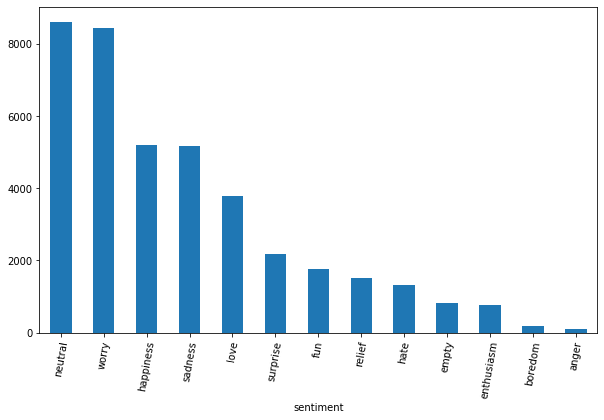

In [14]:
plt.subplots(figsize=(10,6))

df.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [15]:
df.sentiment.value_counts()

neutral       8598
worry         8437
happiness     5184
sadness       5154
love          3785
surprise      2181
fun           1775
relief        1522
hate          1322
empty          822
enthusiasm     758
boredom        179
anger          110
Name: sentiment, dtype: int64

In [16]:
# spacy_tok = spacy.load('en')
# sample_review=df.content[8]
# sample_review

In [17]:
# parsed_review = spacy_tok(sample_review)
# parsed_review

It looks like there are some html characters within the text such as:‘&amp’,’&quot’,etc. For decoding html to general text, beautiful soup can be used

In [18]:
def tweet_cleaner(tweet):
    
#     # To lowercase (not good for VADER)
#     tweet = tweet.lower()
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    #Convert @username to "@user"
    tweet = re.sub('@[^\s]+','@user',tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ')
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    # Remove hyperlinks ->>>> For now just replace with http
    tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)
    
#     # Remove tickers such as USD ($)
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # Remove hashtags (not good for VADER)
#     tweet = re.sub(r'#\w*', '', tweet)
    
#     # Remove Punctuation and split 's, 't, 've with a space for filter
#     tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    
#     # Remove words with 2 or fewer letters
#     tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

    return tweet



# wordpunctok = WordPunctTokenizer()

# pat1 = r'@[A-Za-z0-9_]+'
# pat2 = r'https?://[^ ]+'

# combined_pat = r'|'.join((pat1, pat2))
# www_pat = r'www.[^ ]+'
# negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
#                 "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
#                 "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
#                 "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
#                 "mustn't":"must not"}
# neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

# def tweet_cleaner(text):
#     soup = BeautifulSoup(text, 'lxml')
#     souped = soup.get_text()
#     try:
#         quotRem = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
#     except:
#         quotRem = souped
#     stripped = re.sub(combined_pat, '', quotRem)
#     stripped = re.sub(www_pat, '', stripped)
#     lower_case = stripped.lower()
#     neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
#     letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

#     words = [x for x  in wordpunctok.tokenize(letters_only) if len(x) > 1]
#     return (" ".join(words)).strip()

 

In [19]:

df['Cleaned'] = df.content.apply(tweet_cleaner)
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,@user i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","@user We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging @user why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, he wants me 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm. http is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,@user Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,@user I'm sorry at least it's Friday?


### Removing the stopwords

In [20]:
stop = stopwords.words('english')
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df.head(10)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,@user know listenin bad habit earlier started freakin part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed headache ughhhh...waitin call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang friends SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","@user We want trade someone Houston tickets, one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging @user go prom? BC bf like friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking old friend I want. he's married now. damn, wants 2! scandalous!"
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm. http
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,@user Charlene love. I miss
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,@user I'm sorry least Friday?


### Let's apply a common words filter for removing most common words 

In [21]:
import pickle

MIN_NUMBER_OF_SR = 1000
MIN_COM_WORDS = 0.05
MIN_UNCOM_WORDS = 0.05
UNCOM_WORDS = 0.05
dataframe = df
pivot_feature = 'sentiment'
text_feature = 'Cleaned'

def common_word_filter (dataframe, pivot_feature, text_feature):
    
    NUM_OF_SUB_TECH = len(dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist())
    
    list_common = []
    
    list_uncommon =[]
    
    list_least_common = []
    
    for sub_tech in dataframe[pivot_feature].value_counts()[dataframe[pivot_feature].value_counts() > MIN_NUMBER_OF_SR].index.tolist():
        
        cleaned_text = [str(txt) for text in dataframe[dataframe[pivot_feature] == sub_tech][text_feature] for txt in text.split(' ') if len(txt) > 2 and txt not in ' ']
        
        word_dist = nltk.FreqDist(cleaned_text)
        
        list_common.append([x[0] for x in word_dist.most_common(int(len(word_dist)*MIN_COM_WORDS))])
        
        list_uncommon.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*MIN_UNCOM_WORDS):]])
        
        list_least_common.append([x[0] for x in word_dist.most_common(len(word_dist))[-int(len(word_dist)*UNCOM_WORDS):]])
    
    list_common_fl = [x for y in list_common for x in y]
    
    list_uncommon_fl = [x for y in list_uncommon for x in y]
    
    word_dist_com = nltk.FreqDist(list_common_fl)
    
    word_dist_ucom = nltk.FreqDist(list_uncommon_fl)
    
    list_final_com = [x[0] for x in word_dist_com.most_common(len(list_common_fl)) if x[1] > NUM_OF_SUB_TECH*0.75]
    
    list_final_ucom = [x[0] for x in word_dist_ucom.most_common(len(list_uncommon_fl)) if x[1] < NUM_OF_SUB_TECH*0.25]
    
    final_list = list(set(list_final_com + list_final_ucom + [y for x in list_least_common for y in x]))
    
    with open('common_word_list_for_filtering.pickle', 'wb') as handle:
    
        pickle.dump(final_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return final_list



In [22]:
final_list = common_word_filter(df, 'sentiment','Cleaned')

In [23]:
len(final_list)

5344

In [24]:
len(df.content)

39827

In [25]:
df['Cleaned'] = df['Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_list)]))
df.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin habit earlier started freakin part =[
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n headache ughhhh...waitin call...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade Houston tickets, will."


### We can apply our first models to cleaned content

In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['Cleaned'],
                                                    df['sentiment'],
                                                    test_size=.25, random_state=53)

### Count vectorizing

In [27]:
count_vect2 = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train2 = count_vect2.fit_transform(X_train2)
count_vect_train2 = count_vect_train2.toarray()
count_vect_test2 = count_vect2.transform(X_test2)
count_vect_test2 = count_vect_test2.toarray()

### Logistic Regression

In [28]:
logreg_CV2 = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=1.0,n_jobs=-1, random_state=5)
logreg_CV2.fit(count_vect_train2, y_train2)
y_pred_lr_CV2 = logreg_CV2.predict(count_vect_test2)
print('Accuracy :', metrics.accuracy_score(y_test2, y_pred_lr_CV2))

Accuracy : 0.1841920257105554


Because of the feuture distribution of the sample, we were expecting a low accuracy in our model. In order to balance the distribution, we can update the categorization of the emotions.

We have 13 emotions and we can categorize them in 3 sentiment categories: positive, neutral and negative

anger, boredom, hate, worry, sadness: Negative

happiness, fun, love, surprise, enthusiasm, relief: Positive

empty, neutral : Neutral

In [29]:
dfnew=df.copy()

In [30]:
dfnew.sentiment.replace(['anger','boredom','hate','worry','sadness','happiness','fun','love','surprise','enthusiasm','relief','empty','neutral'],
                    ['negative','negative','negative','negative','negative','positive','positive','positive','positive','positive','positive','neutral','neutral'],
                       inplace=True)

In [31]:
dfnew.head(20)

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin habit earlier started freakin part =[
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n headache ughhhh...waitin call...
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,wants hang SOON!
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.","We trade Houston tickets, will."
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,Re-pinging go prom? BC bf
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!","I sleep, im not! thinking I married damn, wants 2! scandalous!"
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm.
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,Charlene love. I
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,Friday?


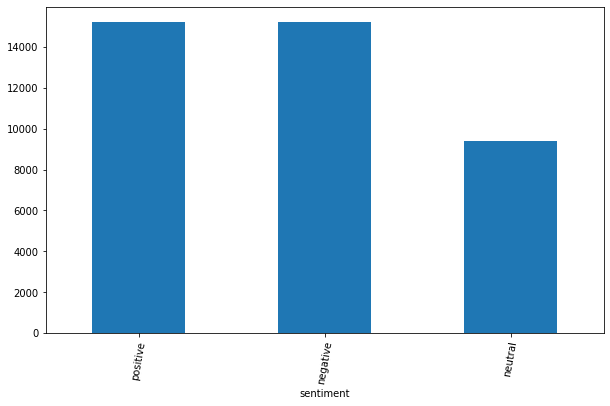

In [32]:
plt.subplots(figsize=(10,6))

dfnew.groupby('sentiment')['content'].count().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=80)
plt.show()

In [34]:
dfnew.head()

,tweet_id,sentiment,author,content,Cleaned
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin habit earlier started freakin part
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n headache ughhhh waitin call
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang soon
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade houston ticket


## Train-Test Split

In [35]:

X_train, X_test, y_train, y_test = train_test_split(dfnew['Cleaned'],
                                                    dfnew['sentiment'],
                                                    test_size=.25, random_state=53)

## Count Vectirizing

In [36]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [37]:
vocab = count_vect.get_feature_names()

In [38]:
pd.DataFrame(count_vect_train, columns=vocab).head(10)

,able,account,ache,add,afternoon,age,ago,agree,ah,ahh,...,yeah,year,yep,yes,yesterday,yet,young,youtube,yr,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

In [39]:

logreg_CV = LogisticRegression(random_state=0)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.5079843326303103


##  Linear SVC

In [40]:

Lsvc = LinearSVC()

Lsvc.fit(count_vect_train, y_train)

pred= Lsvc.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.5079843326303103

## Naive Bayes

In [41]:

from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

nb_classifier.fit(count_vect_train, y_train)

pred = nb_classifier.predict(count_vect_test)

metrics.accuracy_score(y_test, pred)

0.5057748317766395

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.48428241438184194


## Tf-idf Vectorization¶

In [43]:
tfidf_vect = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
vocab = tfidf_vect.get_feature_names()
pd.DataFrame(np.round(tfidf_vect_train, 2), columns=vocab).head(10)

print('Longest word:', max(tfidf_vect.vocabulary_, key=len))

Longest word: michelleeeeeeeeeeeemybelleeeeeeeeeeeeeeeeee


## Logreg after Tf-idf

In [44]:
logreg_TV = LogisticRegression(class_weight='balanced', random_state=5)
logreg_TV.fit(tfidf_vect_train, y_train)
y_pred_lr_TV = logreg_TV.predict(tfidf_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_TV))
print (classification_report(y_test, y_pred_lr_TV))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy : 0.5205383147534398
              precision    recall  f1-score   support

    negative       0.60      0.58      0.59      3871
     neutral       0.33      0.38      0.35      2238
    positive       0.58      0.54      0.56      3848

    accuracy                           0.52      9957
   macro avg       0.50      0.50      0.50      9957
weighted avg       0.53      0.52      0.52      9957



## Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score
cvresult = cross_val_score(logreg_CV, count_vect_train, y_train,cv=5)

print(cvresult)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.50401606 0.4925523  0.50510631 0.50912439 0.49539595]


## Lets try NLTK Vader for sentiment comparison

In [46]:

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [47]:
def sentiment_analyzer_scores(sentence):
    '''
    Evaluates polarity scores of a given sentence and prints the result.
    '''
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

analyzer = SentimentIntensityAnalyzer()

In [48]:

sentiments = []
compounds = []
sid = SentimentIntensityAnalyzer()
for i in dfnew.content:
    sentiment = sid.polarity_scores(i)
    if sentiment['compound']< -0.05:
        sentiments.append('negative')    
    elif sentiment['compound']> 0.05:
        sentiments.append('positive')
    else:
        sentiments.append('neutral')
    compounds.append(sentiment)
    
dfnew['vader'] = pd.DataFrame(sentiments)
dfnew['compound'] = compounds


In [49]:
dfnew.head(30)

,tweet_id,sentiment,author,content,Cleaned,vader,compound
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin habit earlier started freakin part,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,negative,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n headache ughhhh waitin call,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,negative,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,positive,czareaquino,wants to hang out with friends SOON!,want hang soon,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,neutral,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade houston ticket,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,negative,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,go prom bc bf,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,negative,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking married damn want scandalous,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,negative,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,negative,nic0lepaula,@charviray Charlene my love. I miss you,charlene love,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,negative,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,friday,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [50]:
dfnew=dfnew[['tweet_id','author','content','Cleaned','sentiment','vader','compound']]
dfnew.head(30)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
0,1956967341,xoshayzers,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,listenin habit earlier started freakin part,neutral,negative,"{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}"
1,1956967666,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,layin n headache ughhhh waitin call,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
2,1956967696,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,negative,negative,"{'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}"
3,1956967789,czareaquino,wants to hang out with friends SOON!,want hang soon,positive,positive,"{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}"
4,1956968416,xkilljoyx,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",trade houston ticket,neutral,negative,"{'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}"
5,1956968477,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,go prom bc bf,negative,negative,"{'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}"
6,1956968487,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",sleep im thinking married damn want scandalous,negative,negative,"{'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}"
7,1956968636,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
8,1956969035,nic0lepaula,@charviray Charlene my love. I miss you,charlene love,negative,positive,"{'neg': 0.163, 'neu': 0.408, 'pos': 0.429, 'compound': 0.5574}"
9,1956969172,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,friday,negative,negative,"{'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'compound': -0.0772}"


In [51]:
for i in dfnew.index[0:10]:
    print(i)
    sentiment_analyzer_scores(dfnew.content[i])

0
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[ {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound': -0.5423}
1
Layin n bed with a headache  ughhhh...waitin on your call... {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2
Funeral ceremony...gloomy friday...----- {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
3
wants to hang out with friends SOON!---- {'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.5255}
4
@dannycastillo We want to trade with someone who has Houston tickets, but no one will. {'neg': 0.165, 'neu': 0.767, 'pos': 0.068, 'compound': -0.3919}
5
Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends {'neg': 0.264, 'neu': 0.736, 'pos': 0.0, 'compound': -0.5667}
6
I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous! {'neg': 0.26, 'neu': 0.575, 'pos': 0.165, 'compound': -0.6458}
7
Hmmm. http://www.dj

Let's compare the sentiments in our data and the 'Vader' results

In [52]:
(dfnew.sentiment==dfnew.vader).mean()

0.4050267406533256

In [53]:
dfnew[dfnew.sentiment!=dfnew.vader].sample(10)

,tweet_id,author,content,Cleaned,sentiment,vader,compound
26506,1695441161,allysont,@elizabethlai Just study according to the notes that you had to copy and you'll be fine.,study according note copy fine,neutral,negative,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'compound': 0.2023}"
12682,1963700837,mizzdeejaydanja,Cramps . . .,cramp,negative,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
4182,1960261060,RyanELloyd,Is at work,,neutral,positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
14404,1964503382,ShesElectric_,I had my galaxy..and god it was good!! Where has everyone gone..twitters gone a bit quiet xxxxx,god good gone quiet,positive,negative,"{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound': 0.6792}"
33333,1752590471,mamakatz,"@Scorch_Mom Emailed you - it'll be on the porch anytime. If you come tomorrow, we'll have to miss you! Don't worry about knocking!",emailed porch anytime worry knocking,positive,neutral,"{'neg': 0.065, 'neu': 0.813, 'pos': 0.122, 'compound': 0.3378}"
22241,1694384691,smartin58,"@Snowgirl1972 have to avoid the burning desire to say I already have one no, no room for piglets, just enough room for chucks",avoid burning desire room piglet enough room chuck,negative,positive,"{'neg': 0.242, 'neu': 0.659, 'pos': 0.099, 'compound': -0.4404}"
21600,1694258745,idangazit,@rachky @taltalush Yes. I am secure in my masculinity.,yes secure masculinity,neutral,positive,"{'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'compound': 0.6249}"
19987,1966438620,natneagle,@1995shand not quite as much...hmmm products in US that are not in Canada?? Idk Do you have covergirl?,quite much hmmm product u canada idk covergirl,neutral,positive,"{'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'compound': 0.211}"
13677,1964140996,Stephobe,"@mitchelmusso Think you should do a tour in England, we dont got to see any aweomse people !!",think tour england aweomse,positive,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
4815,1960518960,SamanthaaGreco,hearing the birds chirp makes me think its nice outside...well its not rain rain go away!!!,bird chirp outside well go away,positive,neutral,"{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.5684}"


It looks like, our dataset's classification is better than vader's classification. On the other hand, it is obvious that (because twitter texts are very short) our common words cleaner cleaned more than needed. 

## Applying Deep Learning

In [55]:

import keras
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2500,split=' ')
tokenizer.fit_on_texts(dfnew.Cleaned)

print(tokenizer.word_index)

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

{'go': 1, 'u': 2, 'im': 3, 'day': 4, 'oh': 5, 'sad': 6, 'mother': 7, 'today': 8, 'time': 9, 'hate': 10, 'work': 11, 'well': 12, 'love': 13, 'night': 14, 'suck': 15, 'lol': 16, 'please': 17, 'morning': 18, 'one': 19, 'ur': 20, 'feeling': 21, 'sick': 22, 'ok': 23, 'yeah': 24, 'haha': 25, 'week': 26, 'tonight': 27, 'home': 28, 'monday': 29, 'yes': 30, 'x': 31, 'know': 32, 'mom': 33, 'yay': 34, 'tomorrow': 35, 'hurt': 36, 'amazing': 37, 'star': 38, 'sorry': 39, 'ya': 40, 'baby': 41, 'though': 42, 'sound': 43, 'wow': 44, 'fun': 45, 'glad': 46, 'omg': 47, 'ugh': 48, 'lost': 49, 'n': 50, 'great': 51, 'weekend': 52, 'bored': 53, 'world': 54, 'friday': 55, 'hi': 56, 'car': 57, 'birthday': 58, 'must': 59, 'want': 60, 'poor': 61, 'game': 62, 'pic': 63, 'god': 64, 'guy': 65, 'ca': 66, 'kid': 67, 'late': 68, 'gone': 69, 'aww': 70, 'awesome': 71, 'thanks': 72, 'wish': 73, 'say': 74, 'month': 75, 'yesterday': 76, 'anyone': 77, 'twitter': 78, 'listening': 79, 'family': 80, 'year': 81, 'movie': 82, 'ge

In [56]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(dfnew.Cleaned)
X = pad_sequences(X)
print(X)

[[   0    0    0 ...  303  806  192]
 [   0    0    0 ...  130 1692  541]
 [   0    0    0 ... 1693 1545   55]
 ...
 [   0    0    0 ...    4  155  434]
 [   0    0    0 ...    0  208    2]
 [   0    0    0 ...    0 2183 1592]]


In [57]:
Y = []
for val in dfnew.sentiment:
    if(val == 'positive'):
        Y.append([1,0,0])
    elif (val=='neutral'):
        Y.append([0,1,0])
    else:
        Y.append([0,0,1])
Y = np.array(Y)
print(Y)

[[0 1 0]
 [0 0 1]
 [0 0 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [58]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,Y,test_size=0.25)

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

model = Sequential()
model.add(Embedding(2500,128,input_length=X.shape[1],dropout=0.2))
model.add(LSTM(300, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, dropout=0.2, recurrent_dropout=0.2)`
  


In [60]:
model.fit(X_tr ,y_tr, epochs=5,verbose=2,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 106s - loss: 0.9951 - acc: 0.4997
Epoch 2/5
 - 107s - loss: 0.9276 - acc: 0.5533
Epoch 3/5
 - 101s - loss: 0.8945 - acc: 0.5754
Epoch 4/5
 - 108s - loss: 0.8580 - acc: 0.5935
Epoch 5/5
 - 119s - loss: 0.8242 - acc: 0.6118


In [61]:
print(model.evaluate(X_ts,y_ts)[1])

9957/9957 [==============================] - 10s 1ms/step
0.5063774229305221
